# Real Experimental Data

In this notebook we evaluate real experimental data and mainly try to find back the settings of the timeseries data that would be able to reproduces this expermintally. Once that we have that we can for these settings explicitly make predictions. 

But first lets try to make some predictions for the experimental time data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from helpFunctions import *
from generateGLV import *
from fitGLV import *
from mpl_toolkits.mplot3d import Axes3D
import time

First import the experimental time series:

The data file is not clean at all!! The serators are at different lengths and sometimes it starts with " ".

Also it seems that that the entries with a " " added, are special since there the numbers seem to follow a different trend... 

-> I need context Since I do not know what the timedifference is or what the " " infront mean.

-----
Lets for now assume the following:

- The order in which the numbers are the same OTU
- The time between entries are 1 day. Actually it turns out this is not the case!!! -> we should be carefull. Try to get the temporal information from somewhere.

In [26]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f,1):
            pass
    return i 

In [40]:
def readDavid(dataSet = 25):# Either 25 or 28
    fileName = "InputData/David_Data/"+str(dataSet)+"_timeseriess.txt"
    numberTimePoints =  file_len(fileName) - 1 # First line is a header
    with open(fileName,"r") as file:
        numberSpecies = len(file.readline().split()) # Read the header
        timeSeries = -np.ones((numberTimePoints,numberSpecies)) # Default -1 in order to detect potential invalid readings
        for i in range(numberTimePoints): # Read the rest of the Time series
            timeSeries[i] = [float(i) for i in file.readline().split()] # Split line and convert to list of floats
    return timeSeries

Read the data file and prepare do some preprocessing

In [41]:
TS25 = readDavid(dataSet=25)
TS28 = readDavid(dataSet=28)

Relatif total abundancy:

In [44]:
print("25 Relatif abundancy:")
print(np.sum(TS25,axis=0)/np.sum(TS25))
print("28 Relatif abundancy:")
print(np.sum(TS28,axis=0)/np.sum(TS28))

25:
[0.14720545 0.07852464 0.06342329 0.05850057 0.05814592 0.03771862
 0.0367252  0.03587047 0.03556282 0.02284642 0.02273418 0.02247253
 0.02061612 0.01969515 0.01678293 0.01568838 0.01563753 0.0152299
 0.01389646 0.01286855 0.01153141 0.0113297  0.01097469 0.01082526
 0.01062027 0.01009092 0.00922984 0.00895564 0.008576   0.00808725
 0.00788467 0.00780549 0.00734402 0.00680371 0.00667051 0.00614599
 0.00612232 0.0057525  0.00575031 0.00553008 0.005176   0.00490434
 0.00472219 0.0047128  0.00452271 0.00449657 0.00435009 0.00433568
 0.00427756 0.00420004 0.00411857 0.00410268 0.00407034 0.00399891
 0.0039908  0.00374754 0.00364928 0.0035903  0.00343475 0.00342314]
28:
[0.25750578 0.09899051 0.09030803 0.05008315 0.04333838 0.0397626
 0.03363173 0.02615539 0.02359993 0.01981717 0.01793519 0.01786441
 0.01733911 0.01485581 0.01463601 0.0126898  0.01256271 0.01173762
 0.01162124 0.01089113 0.01000517 0.00882287 0.00751242 0.00728452
 0.00720292 0.00648699 0.00634801 0.00617318 0.00615528

Cumulatif total:

In [45]:
print("25 Cumulatif Relatif abundancy:")
print(np.cumsum(np.sum(TS25,axis=0)/np.sum(TS25)))
print("28 Cumulatif Relatif abundancy:")
print(np.cumsum(np.sum(TS28,axis=0)/np.sum(TS28)))

25 Cumulatif Relatif abundancy:
[0.14720545 0.22573009 0.28915338 0.34765396 0.40579988 0.4435185
 0.4802437  0.51611417 0.55167699 0.57452341 0.59725759 0.61973011
 0.64034623 0.66004138 0.67682431 0.69251268 0.70815022 0.72338012
 0.73727658 0.75014513 0.76167654 0.77300624 0.78398093 0.7948062
 0.80542647 0.81551739 0.82474723 0.83370286 0.84227887 0.85036612
 0.85825079 0.86605628 0.8734003  0.880204   0.88687452 0.89302051
 0.89914282 0.90489532 0.91064563 0.91617571 0.92135171 0.92625605
 0.93097824 0.93569104 0.94021375 0.94471032 0.94906041 0.95339609
 0.95767365 0.96187369 0.96599226 0.97009494 0.97416528 0.97816419
 0.98215499 0.98590254 0.98955182 0.99314211 0.99657686 1.        ]
28 Cumulatif Relatif abundancy:
[0.25750578 0.3564963  0.44680433 0.49688748 0.54022586 0.57998845
 0.61362019 0.63977558 0.66337551 0.68319268 0.70112787 0.71899228
 0.73633139 0.75118721 0.76582321 0.77851301 0.79107572 0.80281334
 0.81443458 0.82532571 0.83533087 0.84415375 0.85166616 0.85895068

Let's plot the timeseries with them all stacked

In [72]:
def plotStackPlot(TS,relatif = False):
    fig, ax = plt.subplots(figsize = (15,8))
    x = np.arange(TS.shape[0])
    ax.set_xlabel("Days", fontsize = 15)
    ax.set_xlim([x[0],x[-1]])
    if not relatif:
        ax.stackplot(x, TS.T)
        ax.set_title("absolute Stack plot", fontsize = 18)
        ax.set_ylabel("abundancy", fontsize = 15)
    else:
        TSrelatif = TS/np.sum(TS,axis=1).reshape(-1,1)
        ax.stackplot(x, TSrelatif.T)
        ax.set_title("relatif Stack plot", fontsize = 18)
        ax.set_ylabel("relatif abundancy", fontsize = 15)
        ax.set_ylim([0,1])

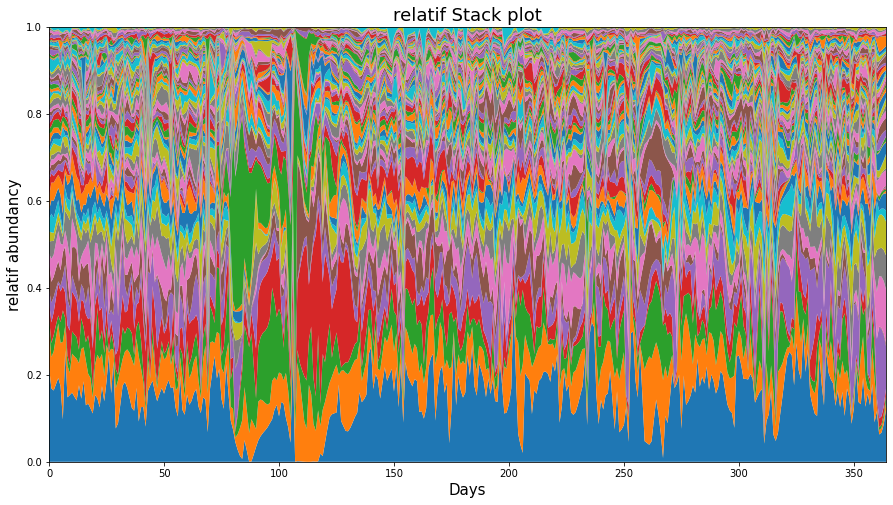

In [82]:
plotStackPlot(TS25, relatif = True)

In [80]:
df = pd.read_csv("InputData/David_Data/MetaData.csv")
df["AGE"]==26

0      True
1      True
2      True
3      True
4      True
       ... 
814    True
815    True
816    True
817    True
818    True
Name: AGE, Length: 819, dtype: bool

In [79]:
df

,Unnamed: 0,AGE,AGE_UNIT,ALTITUDE,ANONYMIZED_NAME,ASSIGNED_FROM_GEO,BODY_HABITAT,BODY_MASS_INDEX,BODY_PRODUCT,BODY_SITE,...,SAMPLE_CENTER,SAMP_SIZE,SEQUENCING_METH,SEX,STUDY_CENTER,STUDY_ID,TARGET_GENE,TARGET_SUBFRAGMENT,TAXON_ID,TITLE
0,Saliva1.1260370,26,years,0,Saliva1,n,UBERON:oral cavity,19.4,UBERON:tongue,UBERON:saliva,...,MIT,".1,g",sequencing by synthesis,male,MIT,2202,16S rRNA,V4,447426,MIT daily human microbiota time-series
1,Saliva10.1259752,26,years,0,Saliva10,n,UBERON:oral cavity,19.4,UBERON:tongue,UBERON:saliva,...,MIT,".1,g",sequencing by synthesis,male,MIT,2202,16S rRNA,V4,447426,MIT daily human microbiota time-series
2,Saliva100.1260165,26,years,0,Saliva100,n,UBERON:oral cavity,19.4,UBERON:tongue,UBERON:saliva,...,MIT,".1,g",sequencing by synthesis,male,MIT,2202,16S rRNA,V4,447426,MIT daily human microbiota time-series
3,Saliva101.1259955,26,years,0,Saliva101,n,UBERON:oral cavity,19.4,UBERON:tongue,UBERON:saliva,...,MIT,".1,g",sequencing by synthesis,male,MIT,2202,16S rRNA,V4,447426,MIT daily human microbiota time-series
4,Saliva102.1259821,26,years,0,Saliva102,n,UBERON:oral cavity,19.4,UBERON:tongue,UBERON:saliva,...,MIT,".1,g",sequencing by synthesis,male,MIT,2202,16S rRNA,V4,447426,MIT daily human microbiota time-series
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,Stool95.1260015,26,years,0,Stool95,n,UBERON:feces,19.4,UBERON:feces,UBERON:feces,...,MIT,".1,g",sequencing by synthesis,male,MIT,2202,16S rRNA,V4,408170,MIT daily human microbiota time-series
815,Stool96.1260429,26,years,0,Stool96,n,UBERON:feces,19.4,UBERON:feces,UBERON:feces,...,MIT,".1,g",sequencing by synthesis,male,MIT,2202,16S rRNA,V4,408170,MIT daily human microbiota time-series
816,Stool97.1260143,26,years,0,Stool97,n,UBERON:feces,19.4,UBERON:feces,UBERON:feces,...,MIT,".1,g",sequencing by synthesis,male,MIT,2202,16S rRNA,V4,408170,MIT daily human microbiota time-series
817,Stool98.1259981,26,years,0,Stool98,n,UBERON:feces,19.4,UBERON:feces,UBERON:feces,...,MIT,".1,g",sequencing by synthesis,male,MIT,2202,16S rRNA,V4,408170,MIT daily human microbiota time-series
